# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import StandardScaler, label_binarize 
from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn import metrics

In [2]:
sns.set_theme(style="whitegrid", palette="Dark2")

# Constants

In [3]:
SEED = 10
N_CLASSES = 7
TEST_SIZE = .2
LR_EPOCHS = 500
CONFIDENCE_THRESH = .8
SPLIT_CLASSES_N = 4

# Data Exploration

In [4]:
fruits = pd.read_excel('data/Date_Fruit_Datasets.xlsx')
fruits

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Class
0,422163,2378.9080,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,...,3.2370,2.9574,4.2287,-59191263232,-50714214400,-39922372608,58.7255,54.9554,47.8400,BERHI
1,338136,2085.1440,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,...,2.6228,2.6350,3.1704,-34233065472,-37462601728,-31477794816,50.0259,52.8168,47.8315,BERHI
2,526843,2647.3940,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,...,3.7516,3.8611,4.7192,-93948354560,-74738221056,-60311207936,65.4772,59.2860,51.9378,BERHI
3,416063,2351.2100,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,...,5.0401,8.6136,8.2618,-32074307584,-32060925952,-29575010304,43.3900,44.1259,41.1882,BERHI
4,347562,2160.3540,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,...,2.7016,2.9761,4.4146,-39980974080,-35980042240,-25593278464,52.7743,50.9080,42.6666,BERHI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,255403,1925.3650,691.8453,477.1796,0.7241,570.2536,0.9785,261028,0.7269,1.4499,...,2.2423,2.3704,2.7202,-25296416768,-19168882688,-18473392128,49.0869,43.0422,42.4153,SOGAY
894,365924,2664.8230,855.4633,551.5447,0.7644,682.5752,0.9466,386566,0.6695,1.5510,...,3.4109,3.5805,3.9910,-31605219328,-21945366528,-19277905920,46.8086,39.1046,36.5502,SOGAY
895,254330,1926.7360,747.4943,435.6219,0.8126,569.0545,0.9925,256255,0.7240,1.7159,...,2.2759,2.5090,2.6951,-22242772992,-19594921984,-17592152064,44.1325,40.7986,40.9769,SOGAY
896,238955,1906.2679,716.6485,441.8297,0.7873,551.5859,0.9604,248795,0.6954,1.6220,...,2.6769,2.6874,2.7991,-26048595968,-21299822592,-19809978368,51.2267,45.7162,45.6260,SOGAY


In [5]:
print(fruits.isna().sum().sum())
fruits.describe()

0


,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,...,898.000000,898.000000,898.000000,898.000000,8.980000e+02,8.980000e+02,8.980000e+02,898.000000,898.000000,898.000000
mean,298295.207127,2057.660953,750.811994,495.872785,0.737468,604.577938,0.981840,303845.592428,0.736267,2.131102,...,0.250518,4.247845,5.110894,3.780928,-3.185021e+10,-2.901860e+10,-2.771876e+10,50.082888,48.805681,48.098393
std,107245.205337,410.012459,144.059326,114.268917,0.088727,119.593888,0.018157,108815.656947,0.053745,17.820778,...,0.632918,2.892357,3.745463,2.049831,2.037241e+10,1.712952e+10,1.484137e+10,16.063125,14.125911,10.813862
min,1987.000000,911.828000,336.722700,2.283200,0.344800,50.298400,0.836600,2257.000000,0.512300,1.065300,...,-1.029100,1.708200,1.607600,1.767200,-1.091224e+11,-9.261697e+10,-8.747177e+10,15.191100,20.524700,22.130000
25%,206948.000000,1726.091500,641.068650,404.684375,0.685625,513.317075,0.978825,210022.750000,0.705875,1.373725,...,-0.196950,2.536625,2.508850,2.577275,-4.429444e+10,-3.894638e+10,-3.564534e+10,38.224425,38.654525,39.250725
50%,319833.000000,2196.345450,791.363400,495.054850,0.754700,638.140950,0.987300,327207.000000,0.746950,1.524150,...,0.135550,3.069800,3.127800,3.080700,-2.826156e+10,-2.620990e+10,-2.392928e+10,53.841300,50.337800,49.614100
75%,382573.000000,2389.716575,858.633750,589.031700,0.802150,697.930525,0.991800,388804.000000,0.775850,1.674750,...,0.593950,4.449850,7.320400,4.283125,-1.460482e+10,-1.433105e+10,-1.660367e+10,63.063350,59.573600,56.666675
max,546063.000000,2811.997100,1222.723000,766.453600,1.000000,833.827900,0.997400,552598.000000,0.856200,535.525700,...,3.092300,26.171100,26.736700,32.249500,-1.627316e+08,-5.627727e+08,-4.370435e+08,79.828900,83.064900,74.104600


In [6]:
def view_boxplots(d=pd.DataFrame(), x=[], y=None, r=9, c=4, size=[14,14], outlier_size=4, title='', legend=[], legend_pos=(.99, 0.09), legend_cols=4):
    """"""
    fig, ax = plt.subplots(r, c, figsize=size, constrained_layout=True)
    ranges = [(i,j) for i in range(r) for j in range(c)]
    for xi,(i,j) in zip(x,ranges):
        sns.boxplot(ax=ax[i,j], data=d, x=xi, y=y, orient='h', hue=y, fliersize=outlier_size, legend=legend)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].legend_.remove()

    for k in range(len(x), r*c): ax[*ranges[k]].axis('off')
    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=12, bbox_to_anchor=legend_pos, ncol=legend_cols)
    fig.suptitle(title, size=18)

def view_barplot(x, size=[10,7]):
    """"""
    plt.figure(figsize=size)
    ax = sns.barplot(x, estimator='sum', linewidth=1, edgecolor=".3")
    ax.bar_label(ax.containers[0], fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()


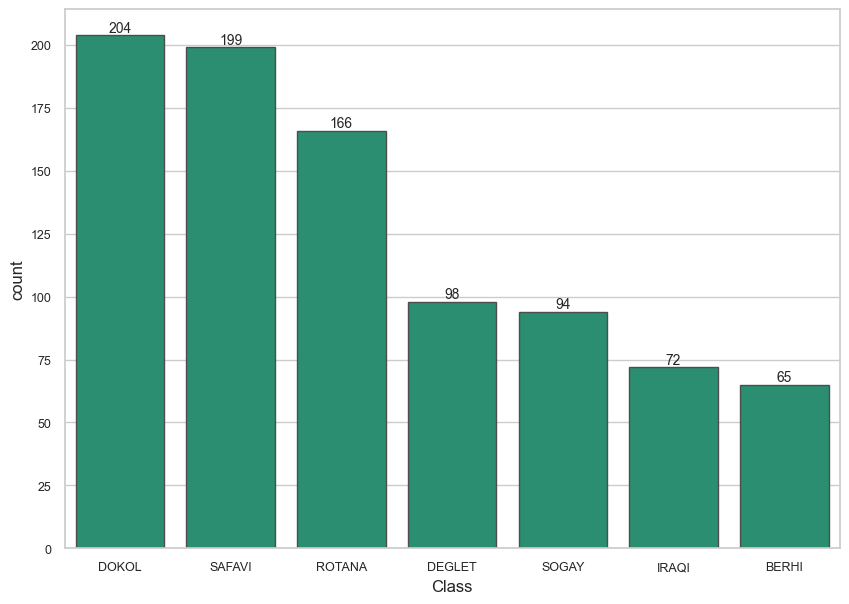

In [7]:
view_barplot(fruits.Class.value_counts())

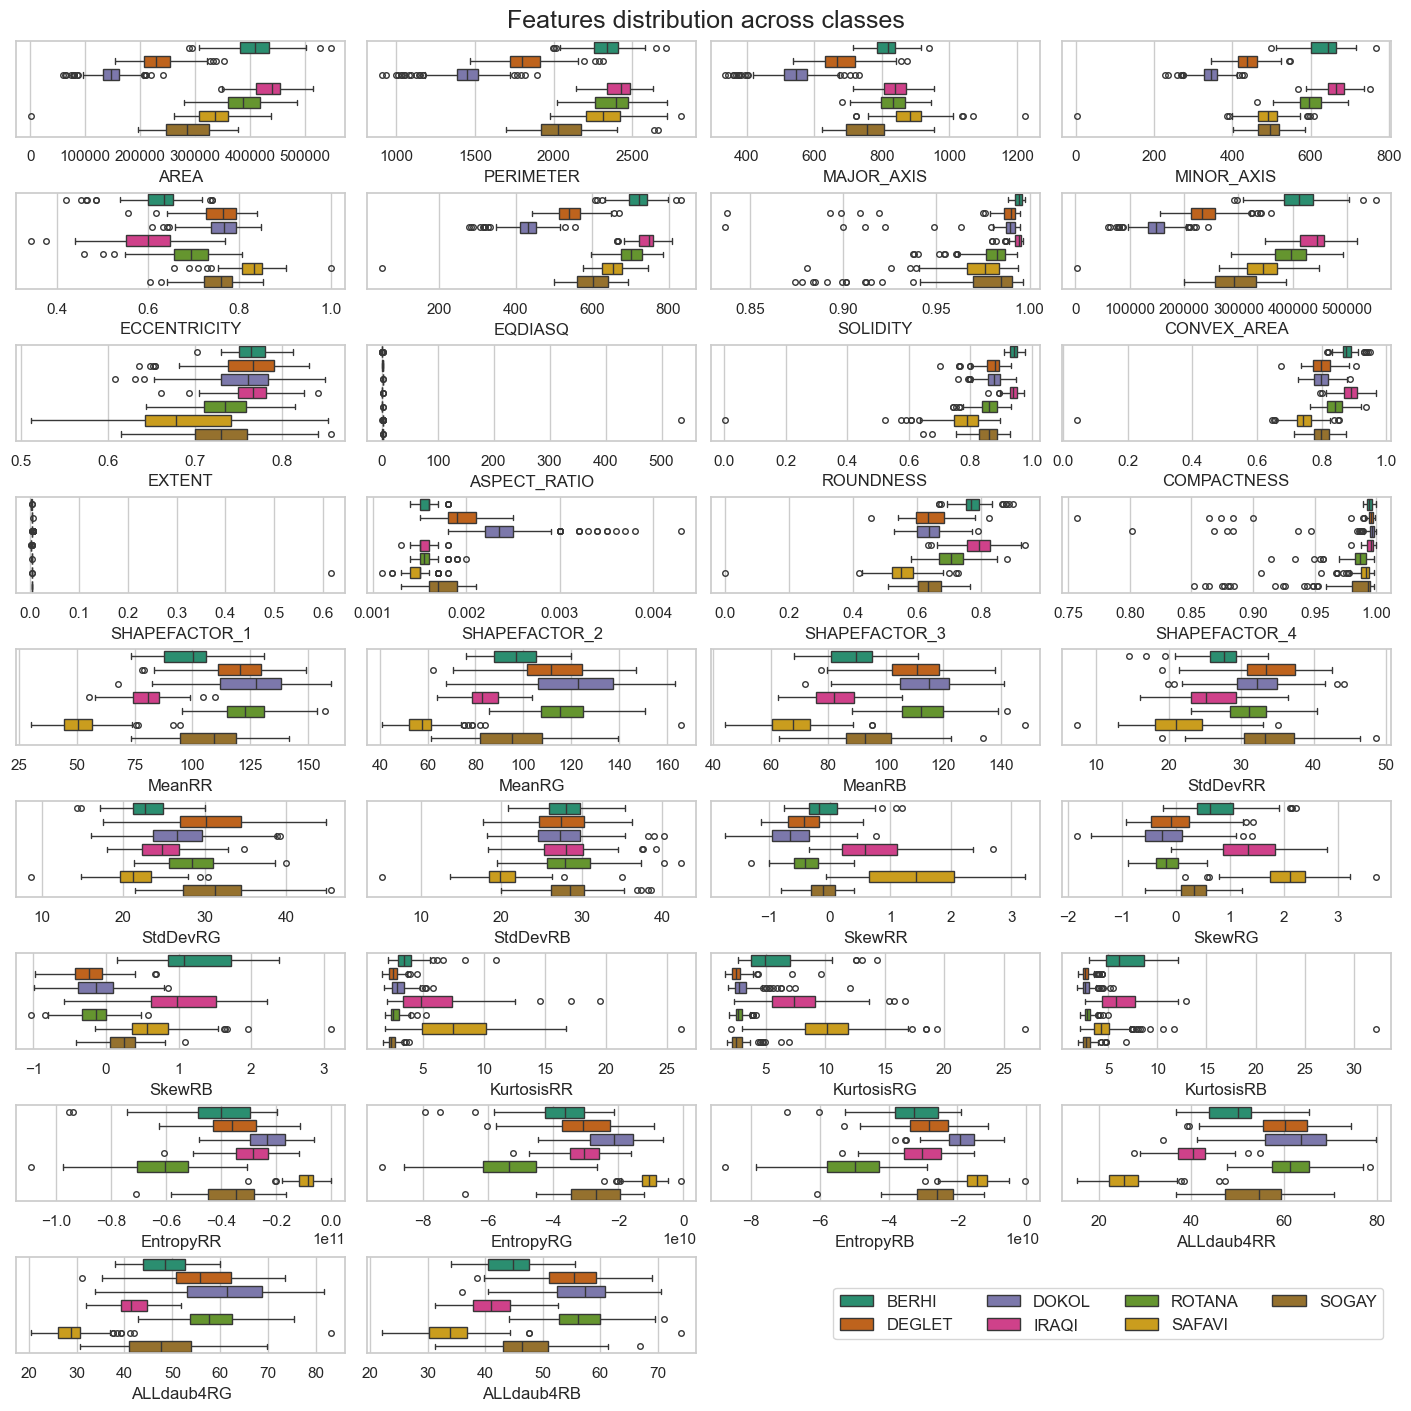

In [8]:
view_boxplots(fruits, x=fruits.columns[:-1], y='Class', legend=list(fruits.Class.unique()), title='Features distribution across classes')

# Data Preperation 
## Removing outlier

615    0.6154
Name: SHAPEFACTOR_1, dtype: float64


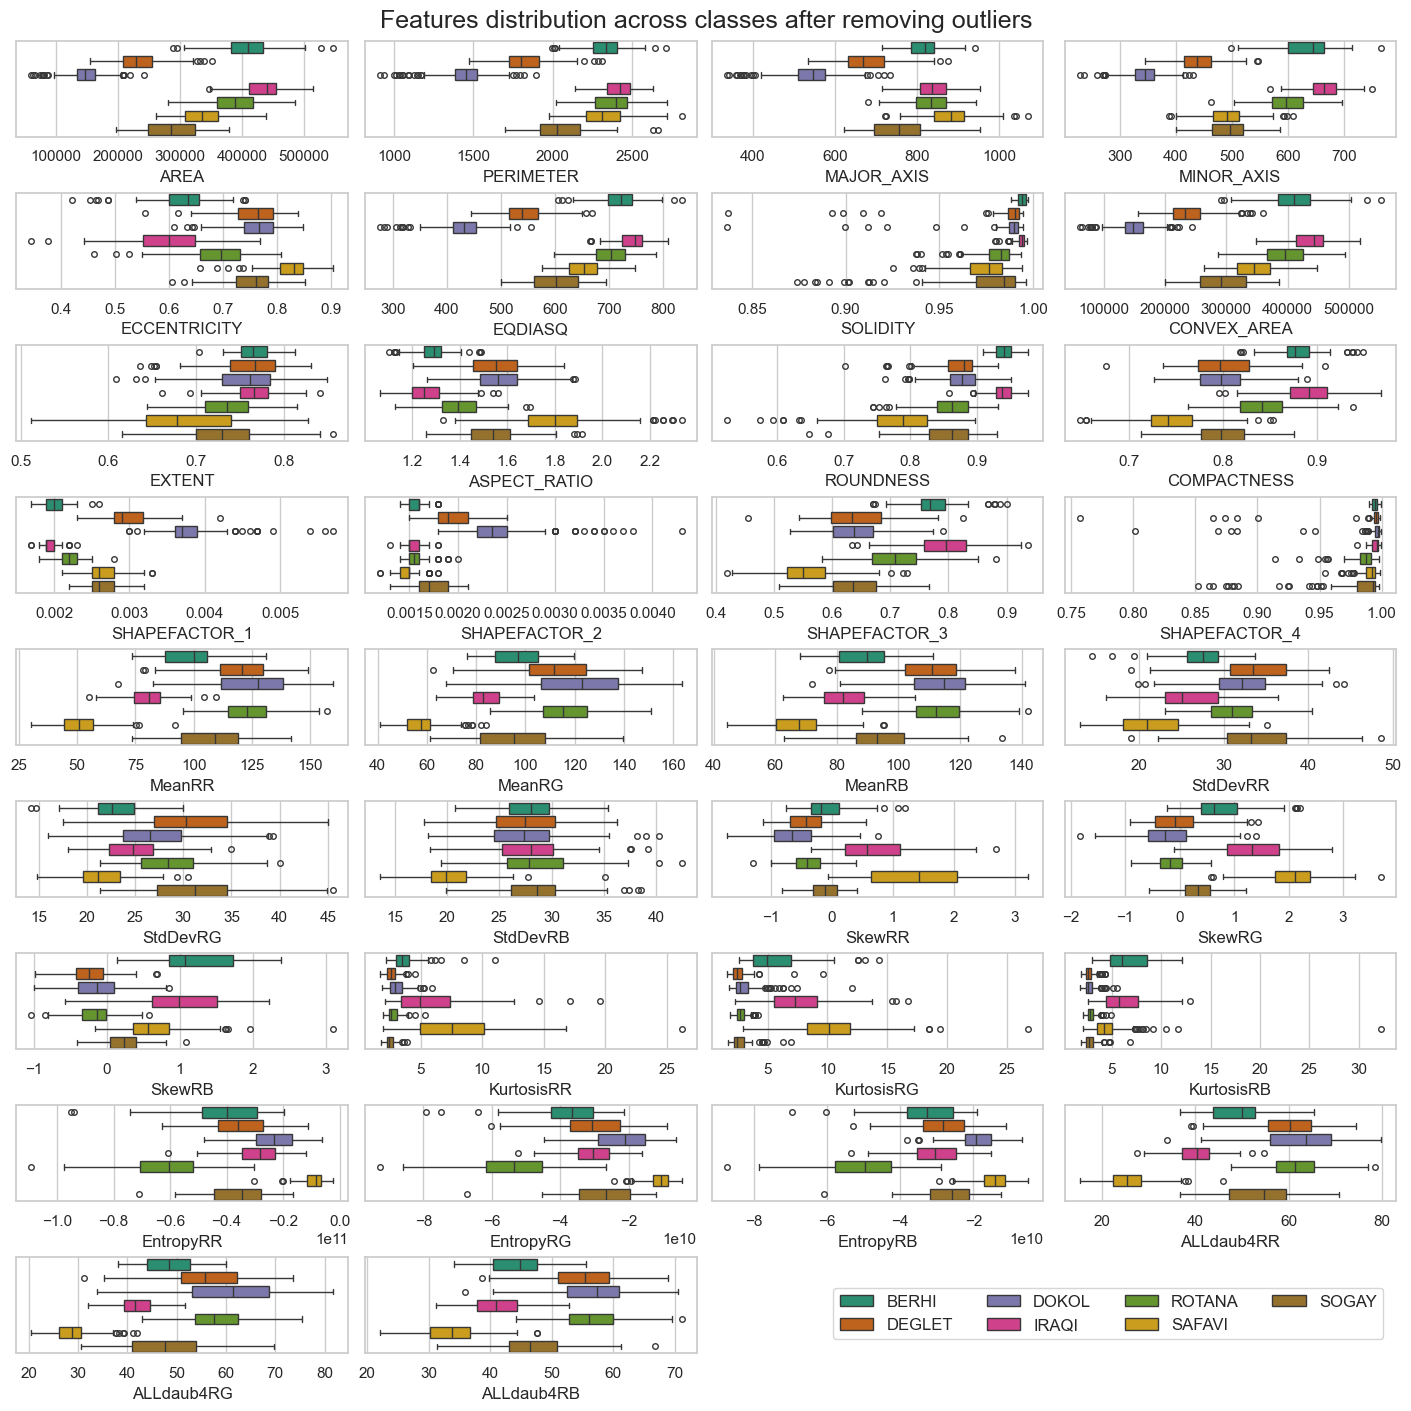

In [9]:
print(fruits[fruits.ASPECT_RATIO>500].SHAPEFACTOR_1)
fruits.drop(fruits[fruits.ASPECT_RATIO>500].index, inplace=True)
view_boxplots(fruits, x=fruits.columns[:-1], y='Class', legend=list(fruits.Class.unique()), title='Features distribution across classes after removing outliers')

In [10]:
class_to_num = {fruits.Class.unique()[i] : i for i in range(len(fruits.Class.unique()))}
num_to_class = {v:k for k,v in class_to_num.items()}
num_to_class

{0: 'BERHI',
 1: 'DEGLET',
 2: 'DOKOL',
 3: 'IRAQI',
 4: 'ROTANA',
 5: 'SAFAVI',
 6: 'SOGAY'}

## Train test split

In [11]:
features, target = fruits.drop(columns=['Class']), (fruits.Class).map(class_to_num)
x_train, x_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=TEST_SIZE, random_state=SEED)

# Modeling
### ( + SMOTE oversamping )

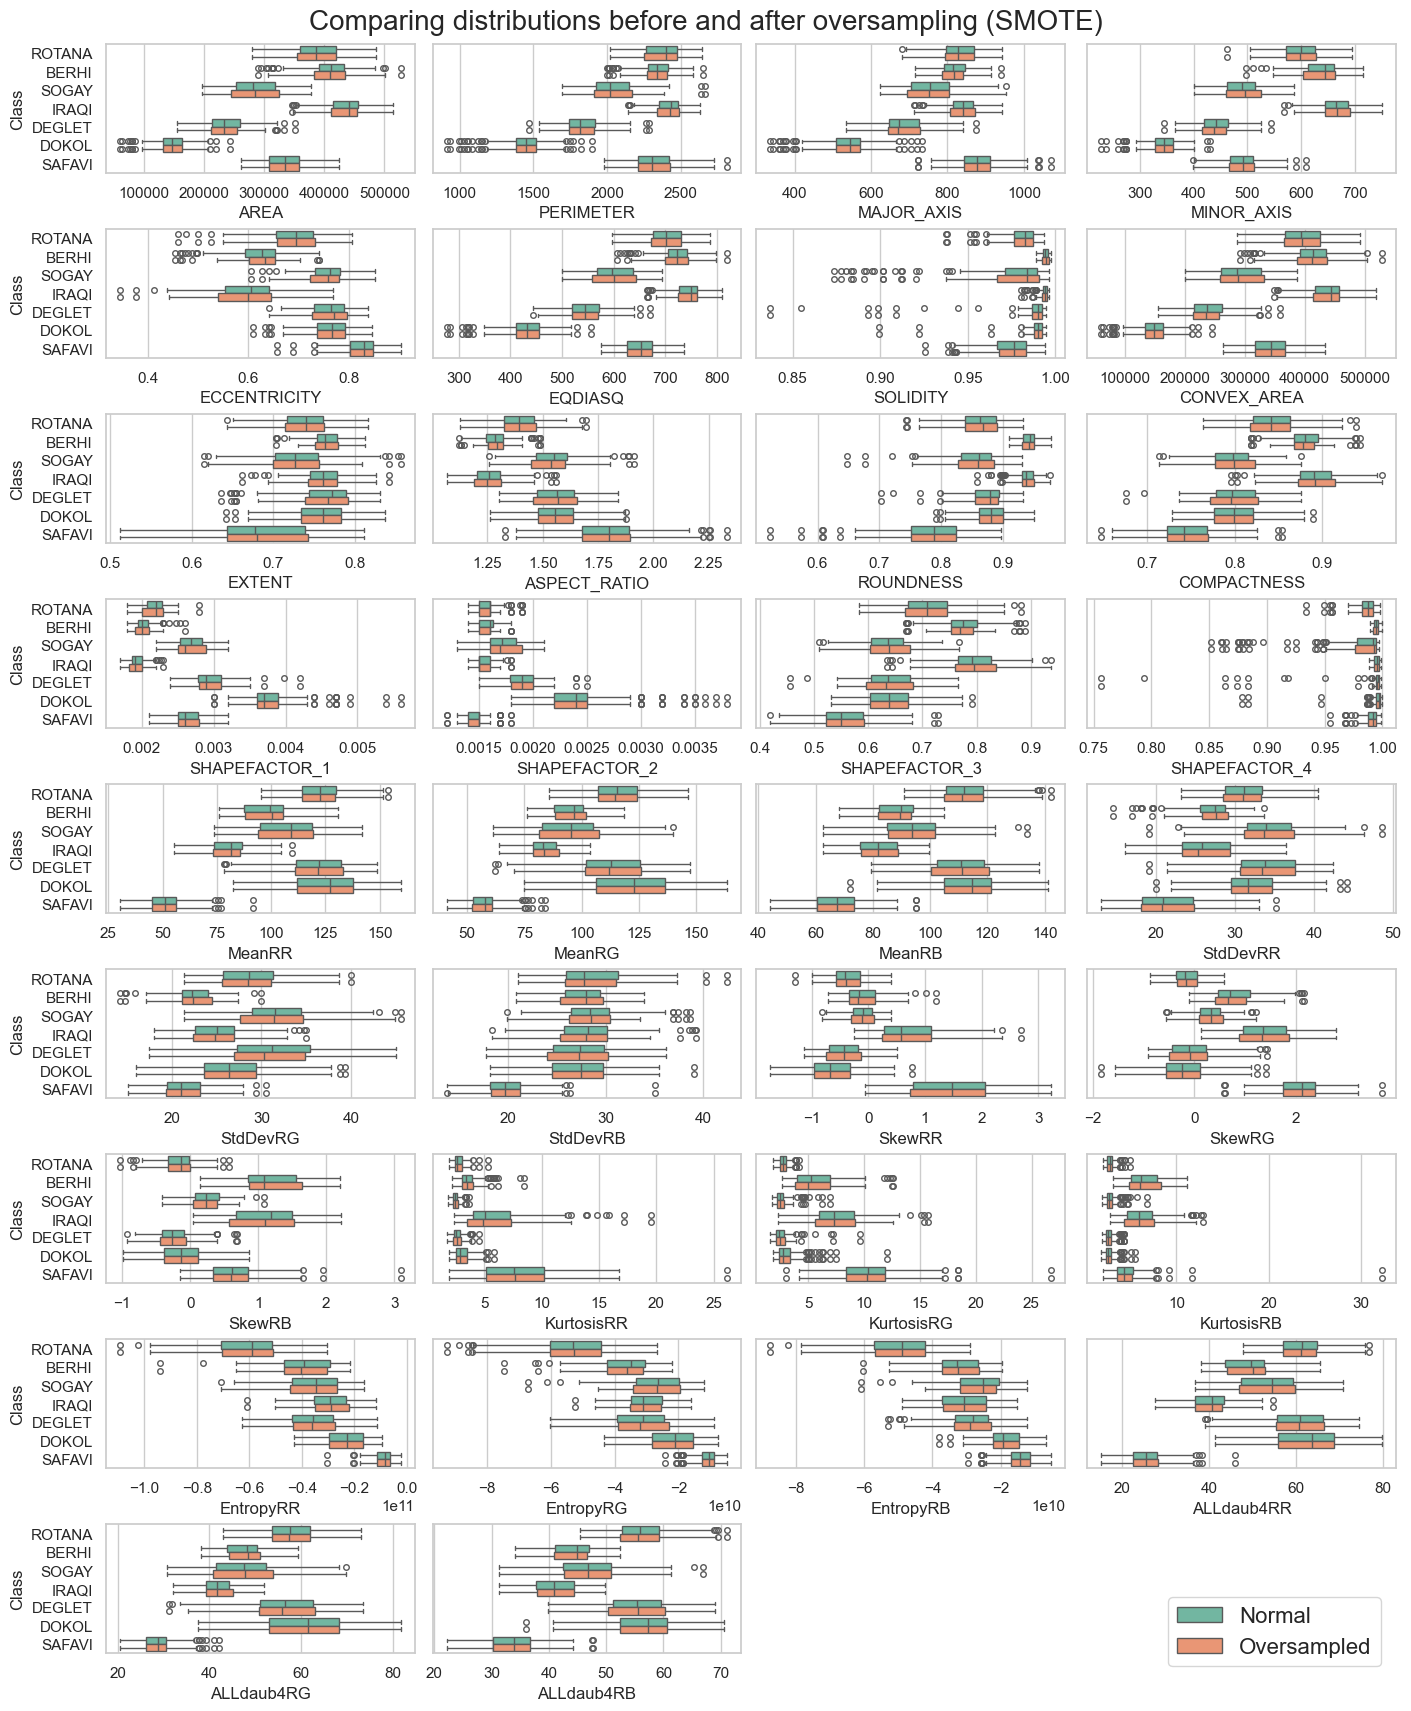

In [12]:
def compare_distribution(data_1, data_2, x, y, hue='SMOTE', r=9, c=4, size=[14, 17], outlier_size=4, title='', legend_pos=(.99, 0.07)):
    """"""
    data_1_, data_2_ = data_1.copy(), data_2.copy()
    data_1_[hue], data_2_[hue] = 'Normal', 'Oversampled'
    data = pd.concat([data_1_, data_2_])
    fig, ax = plt.subplots(r, c, figsize=size, constrained_layout=True)
    ranges = [(i,j) for i in range(r) for j in range(c)]
    for xi,(i,j) in zip(x,ranges):
        sns.boxplot(ax=ax[i,j], data=data, x=xi, y=y, orient='h', hue=hue, palette='Set2',
                     fliersize=outlier_size)
        if j!=0 : ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].legend_.remove()

    for k in range(len(x), r*c): ax[*ranges[k]].axis('off')
    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=16, bbox_to_anchor=legend_pos)
    fig.suptitle(title, size=20)

def oversample(x, y, method=SMOTE, **kwargs):
    ov_kwargs = {k:v for k,v in kwargs.items() if k in method.__init__.__code__.co_varnames}
    oversampler = method(**ov_kwargs)
    return shuffle(*oversampler.fit_resample(x, y), random_state=SEED)

x_ov, y_ov = oversample(x_train, y_train) 
compare_distribution(pd.concat([x_ov,y_ov.map(num_to_class)], axis=1), pd.concat([x_train, y_train.map(num_to_class)], axis=1),
                      x=x_train.columns, y='Class', title='Comparing distributions before and after oversampling (SMOTE)')

In [13]:
def eval_model(Y, y, funcs): return pd.Series({func.__name__ : func(Y,y) for func in funcs})

def scale_data(data, scaling_method=StandardScaler):
    scaler = scaling_method()
    scaler.fit(data)
    return scaler.transform(data), scaler

def train_simple(model_name, x_train, y_train, **kwargs):
    model_def = model_name(**kwargs)
    model = model_def.fit(x_train, y_train)
    return model, model_def

def train(model_name, x_train, y_train, oversampling=True, scaling=True, **kwargs):
    tr_kwargs = {k:v for k,v in kwargs.items() if k in model_name.__init__.__code__.co_varnames}
    x_train_, y_train_ = x_train.copy(), y_train.copy()
    if oversampling : x_train_, y_train_ = oversample(x_train_,  y_train_, **kwargs)
    if scaling : x_train_, scaler = scale_data(x_train_, kwargs['scaling_method'] if 'scaling_method' in kwargs.keys() else StandardScaler)
    else : scaler = None
    model_def = model_name(**tr_kwargs)
    model = model_def.fit(x_train_, y_train_)
    return model, model_def, x_train_, y_train_, scaler

In [14]:
def view_learning_curve(model ,X, Y, metrics, cv=5, train_sizes=np.linspace(0.15, 1.0, 40), r=1, c=3, title='', size=[14,4], s=4):
    fig, ax = plt.subplots(r,c, figsize=size, layout='constrained')
    indices = [(i,j) for i in range(r) for j in range(c)]
    for (i,j), metric in zip(indices, metrics):
        LearningCurveDisplay.from_estimator(
            model, X, Y, cv=cv, 
            scoring=metric, line_kw={"marker": "o", "markersize": s},

            train_sizes=train_sizes, n_jobs=-1, ax=ax[(i,j) if r>1 else j]) 
        
def plot_pr_curve(ax, y_score, y_test, name='Micro-avg', type='mean', n=N_CLASSES, map_dict=num_to_class, alpha=.5, chance_level=True):
    """"""
    y_test_bin = label_binarize(y_test, classes=list(range(N_CLASSES)))
    precision, recall, average_precision = dict(), dict(), dict()
    for i in range(n):
        precision[i], recall[i], _ = metrics.precision_recall_curve(y_test_bin[:,i], y_score[:,i])
        average_precision[i] = metrics.average_precision_score(y_test_bin[:,i], y_score[:,i])
    precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
    average_precision["micro"] = metrics.average_precision_score(y_test_bin, y_score, average="micro")
    if type in ['per_class', 'both']:
        for i in range(n):
            pr_class = metrics.PrecisionRecallDisplay( recall=recall[i], precision=precision[i], 
                                            average_precision=average_precision[i],
                                            estimator_name=map_dict[i].capitalize() )
            pr_class.plot(ax=ax, alpha=.5)
    if type in ['mean', 'both']:
        pr_mean = metrics.PrecisionRecallDisplay( recall=recall["micro"], precision=precision["micro"], 
                                            average_precision=average_precision["micro"], 
                                            prevalence_pos_label=y_test_bin.sum()/y_test_bin.size, 
                                            estimator_name=name )
        pr_mean.plot(ax=ax, plot_chance_level=chance_level, despine=True)
    ax.legend(fontsize=10, ncol=1 if type=='mean' else 3)
        
def plot_roc_curve(ax, y_score, y_test, name="Micro-average OvR", type='mean', n=N_CLASSES, map_dict=num_to_class, alpha=.5):
    """"""
    y_test_bin = label_binarize(y_test, classes=list(range(N_CLASSES)))
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:,i], y_score[:,i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    fpr['micro'], tpr['micro'], _ = metrics.roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc['micro'] = metrics.auc(fpr['micro'], tpr['micro'])
    if type in ['per_class', 'both']:
        for i in range(n):
            roc_class = metrics.RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], name=map_dict[i].capitalize())
            roc_class.plot(ax=ax, alpha=.5)
    if type in ['mean', 'both']:
        roc_mean = metrics.RocCurveDisplay(fpr=fpr['micro'], tpr=tpr['micro'], roc_auc=roc_auc['micro'], name=name)
        roc_mean.plot(ax=ax)
    ax.legend(fontsize=10, ncol=1 if type=='mean' else 2)
    
def plot_calibration_curve(ax, y_score, y_test, name="Micro-average OvR", bins=5, type='mean', n=N_CLASSES, map_dict=num_to_class, alpha=.5):
    """"""
    y_test_bin = label_binarize(y_test, classes=list(range(n)))
    prob_true, prob_pred = dict(), dict()
    for i in range(n):
        prob_true[i], prob_pred[i] = calibration_curve(y_test_bin[:,i], y_score[:,i], n_bins=bins-2 if bins>2 else bins)
    prob_true['micro'], prob_pred['micro'] = calibration_curve(y_test_bin.ravel(), y_score.ravel(), n_bins=bins)
    if type in ['per_class', 'both']:
        for i in range(n):
            calib_class = CalibrationDisplay(prob_true=prob_true[i], prob_pred=prob_pred[i], y_prob=y_score[i],
                                             estimator_name=map_dict[i].capitalize())
            calib_class.plot(ax=ax, alpha=.5)
    if type in ['mean', 'both']:
        calib_mean = CalibrationDisplay(prob_true=prob_true['micro'], prob_pred=prob_pred['micro'], y_prob=y_score.ravel(),
                                        estimator_name=name)
        calib_mean.plot(ax=ax)
    ax.legend(fontsize=10, ncol=1)

def eval_summary(y_score, y_proba, y_test, size=[14,14], names=['Micro-avg','Micro-average OvR', 'Micro-average OvR'], 
                 bins=5, types=['both', 'both', 'both'], title='', n=N_CLASSES, map_dict=num_to_class, alpha=.5):
    """"""
    fig, ax = plt.subplot_mosaic([['pr', 'roc'],['cal', 'cal']], figsize=size, layout='constrained')
    plot_pr_curve(ax['pr'], y_score, y_test, name=names[0], type=types[0], n=n, map_dict=map_dict, alpha=alpha)
    plot_roc_curve(ax['roc'], y_score, y_test, name=names[1], type=types[1], n=n, map_dict=map_dict, alpha=alpha)
    plot_calibration_curve(ax['cal'], y_proba, y_test, name=names[2], type=types[2], bins=bins, n=n, map_dict=map_dict, alpha=alpha)
    fig.suptitle(title, size=18)

### Training & Evaluation

              precision    recall  f1-score   support

       BERHI     0.9167    0.8462    0.8800        13
      DEGLET     0.7895    0.7500    0.7692        20
       DOKOL     0.9500    0.9268    0.9383        41
       IRAQI     0.9286    0.9286    0.9286        14
      ROTANA     0.9167    1.0000    0.9565        33
      SAFAVI     1.0000    1.0000    1.0000        40
       SOGAY     0.8421    0.8421    0.8421        19

    accuracy                         0.9222       180
   macro avg     0.9062    0.8991    0.9021       180
weighted avg     0.9217    0.9222    0.9214       180



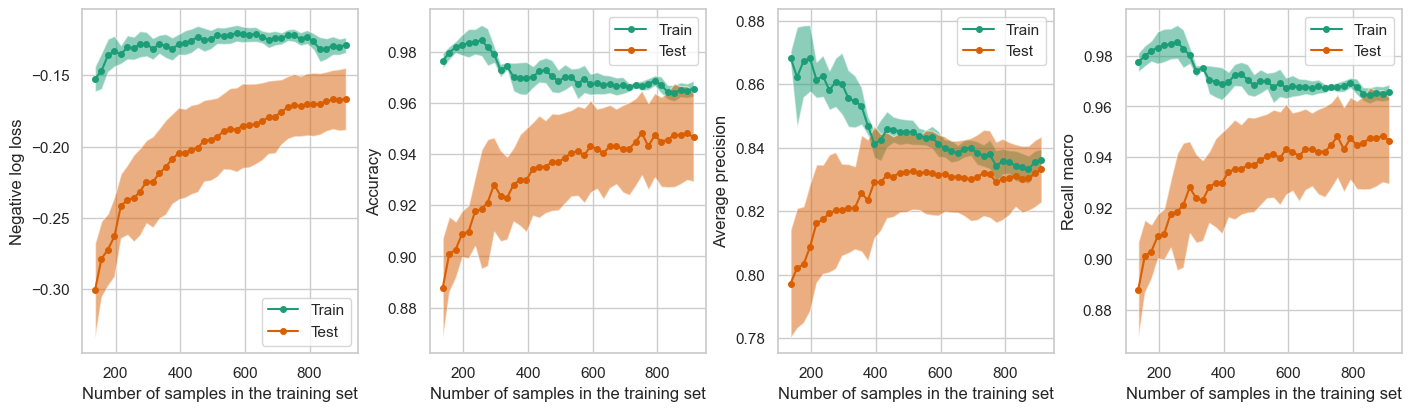

In [15]:
clf, _, x_train_smote, y_train_smote, scaler = train(LogisticRegression,
                                                     x_train, y_train,
                                                     penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
x_test_ = scaler.transform(x_test)
print(metrics.classification_report(y_test, clf.predict(x_test_), 
            labels=list(range(N_CLASSES)), target_names=list(fruits.Class.unique()),  digits=4))
view_learning_curve(clf, x_train_smote, y_train_smote, ['neg_log_loss', 'accuracy', 'average_precision', 'recall_macro'], r=1, c=4, size=[14,4])

c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


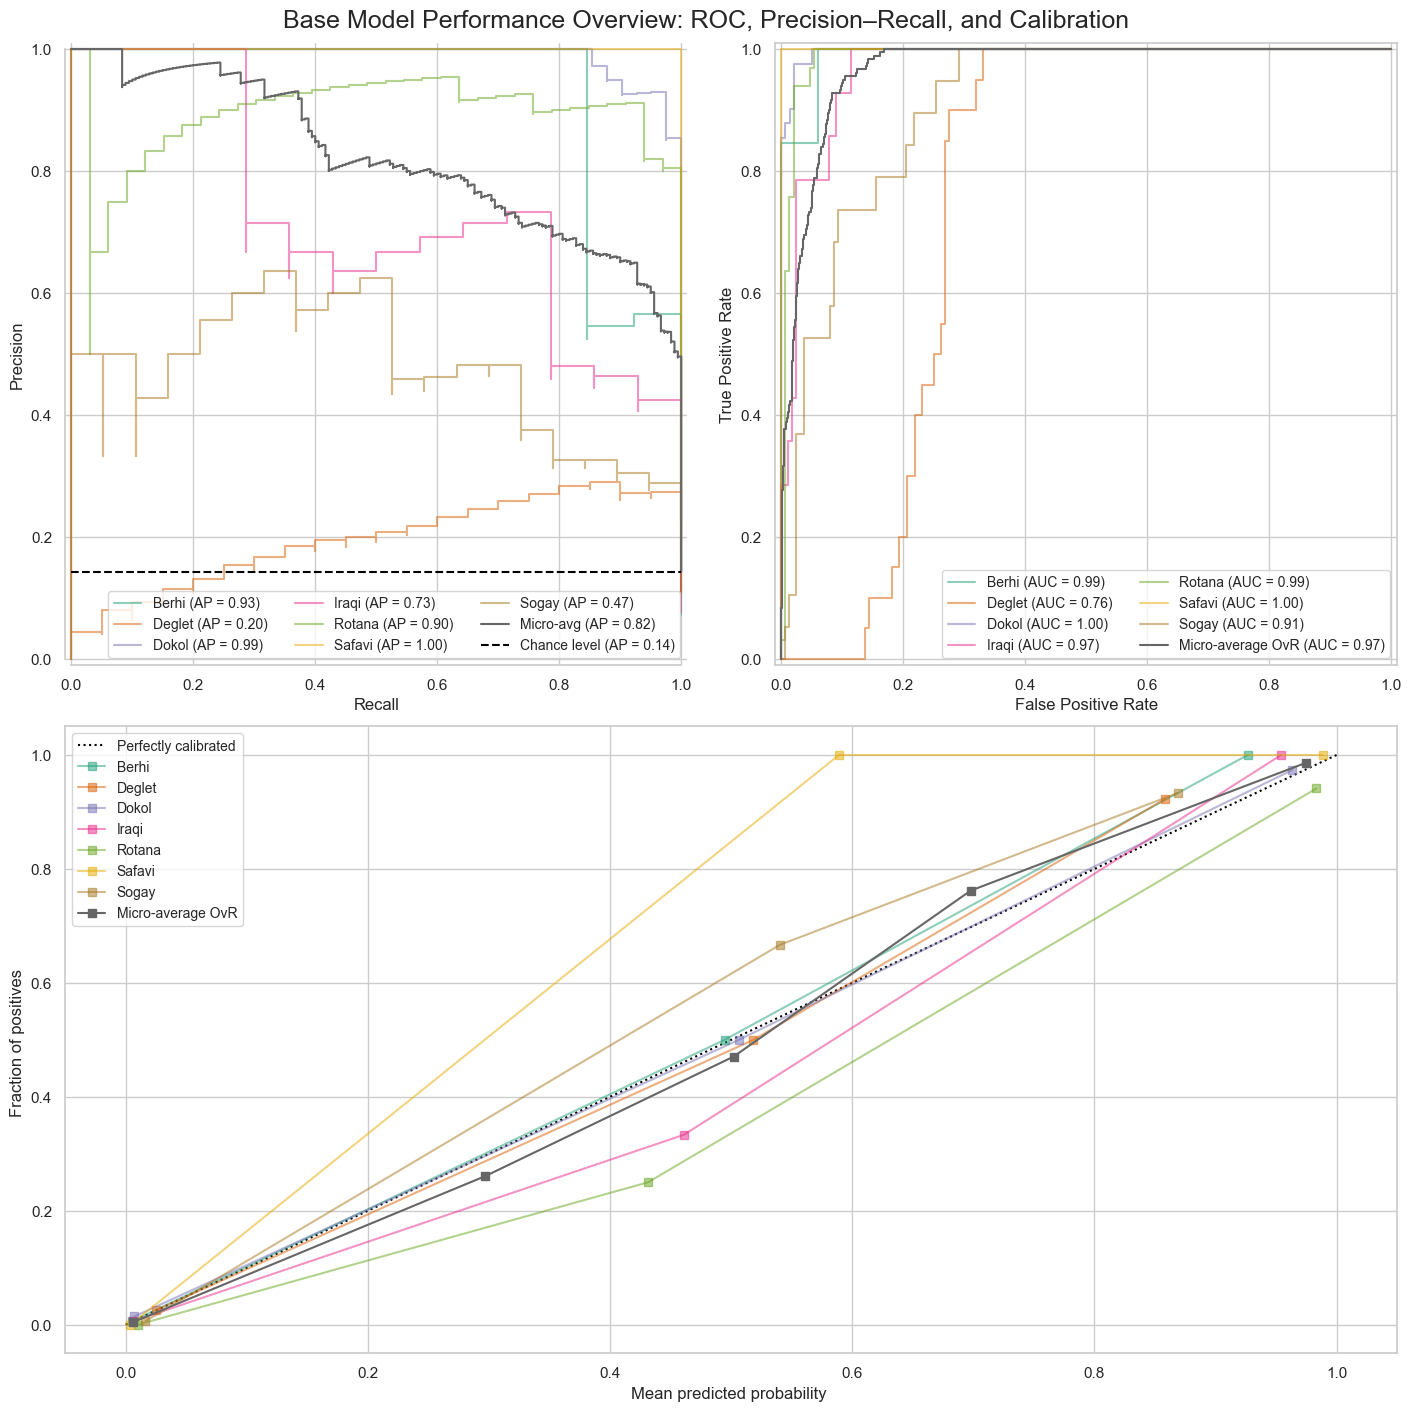

In [16]:
y_score = clf.decision_function(scaler.transform(x_test))
y_proba = clf.predict_proba(scaler.transform(x_test))
eval_summary(y_score, y_proba, y_test, title='Base Model Performance Overview: ROC, Precision–Recall, and Calibration')

## Enhancing Model
### Attempt I - Reducing feature vector using p-values

c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 0.467650
         Iterations 33
Minor Features : ['ASPECT_RATIO', 'MeanRR', 'MeanRG', 'MeanRB', 'StdDevRR', 'SkewRR', 'ALLdaub4RR', 'ALLdaub4RG', 'ALLdaub4RB']
              precision    recall  f1-score   support

       BERHI     1.0000    0.8462    0.9167        13
      DEGLET     0.8824    0.7500    0.8108        20
       DOKOL     0.9500    0.9268    0.9383        41
       IRAQI     0.9286    0.9286    0.9286        14
      ROTANA     0.9167    1.0000    0.9565        33
      SAFAVI     1.0000    1.0000    1.0000        40
       SOGAY     0.8636    1.0000    0.9268        19

    accuracy                         0.9389       180
   macro avg     0.9345    0.9217    0.9254       180
weighted avg     0.9403    0.9389    0.9376       180



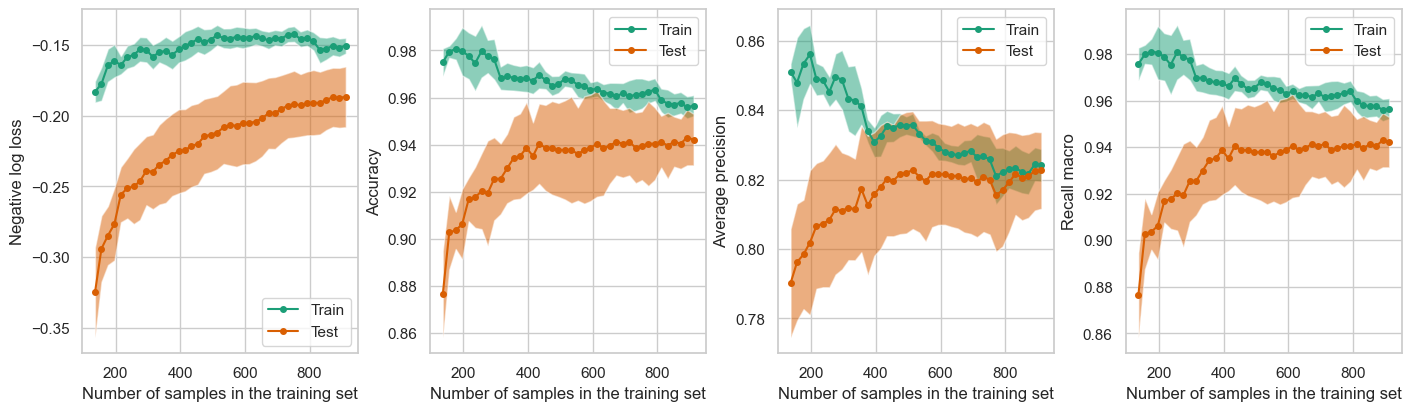

In [17]:
def reduce_features_sm(sm_model_name, x, y, n_iter=100, confidence_level=CONFIDENCE_THRESH, columns=features.columns):
    sm_model = sm_model_name(y/y.max(), sm.add_constant(x))
    sm_res = sm_model.fit(max_iter=n_iter)
    pvalues = pd.DataFrame(np.array(sm_res.pvalues[1:]).reshape(1,-1), columns=columns)
    minor_features = pvalues[pvalues>confidence_level].dropna(axis=1).columns
    return pvalues, minor_features, sm_res 

pvalues, minor_features, sm_res = reduce_features_sm(sm.Logit, x_train_smote, y_train_smote)
print('Minor Features :', list(minor_features))
clf_0, _, x_train_smote_0, y_train_smote_0, scaler_0 = train(LogisticRegression,
                                                     x_train.drop(columns=minor_features), y_train,
                                                     penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
x_test_ = scaler_0.transform(x_test.drop(columns=minor_features))
print(metrics.classification_report(y_test, clf_0.predict(x_test_), 
            labels=list(range(7)), target_names=list(fruits.Class.unique()),  digits=4))

view_learning_curve(clf_0, x_train_smote_0, y_train_smote_0, ['neg_log_loss', 'accuracy', 'average_precision',  'recall_macro'], r=1, c=4)

c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


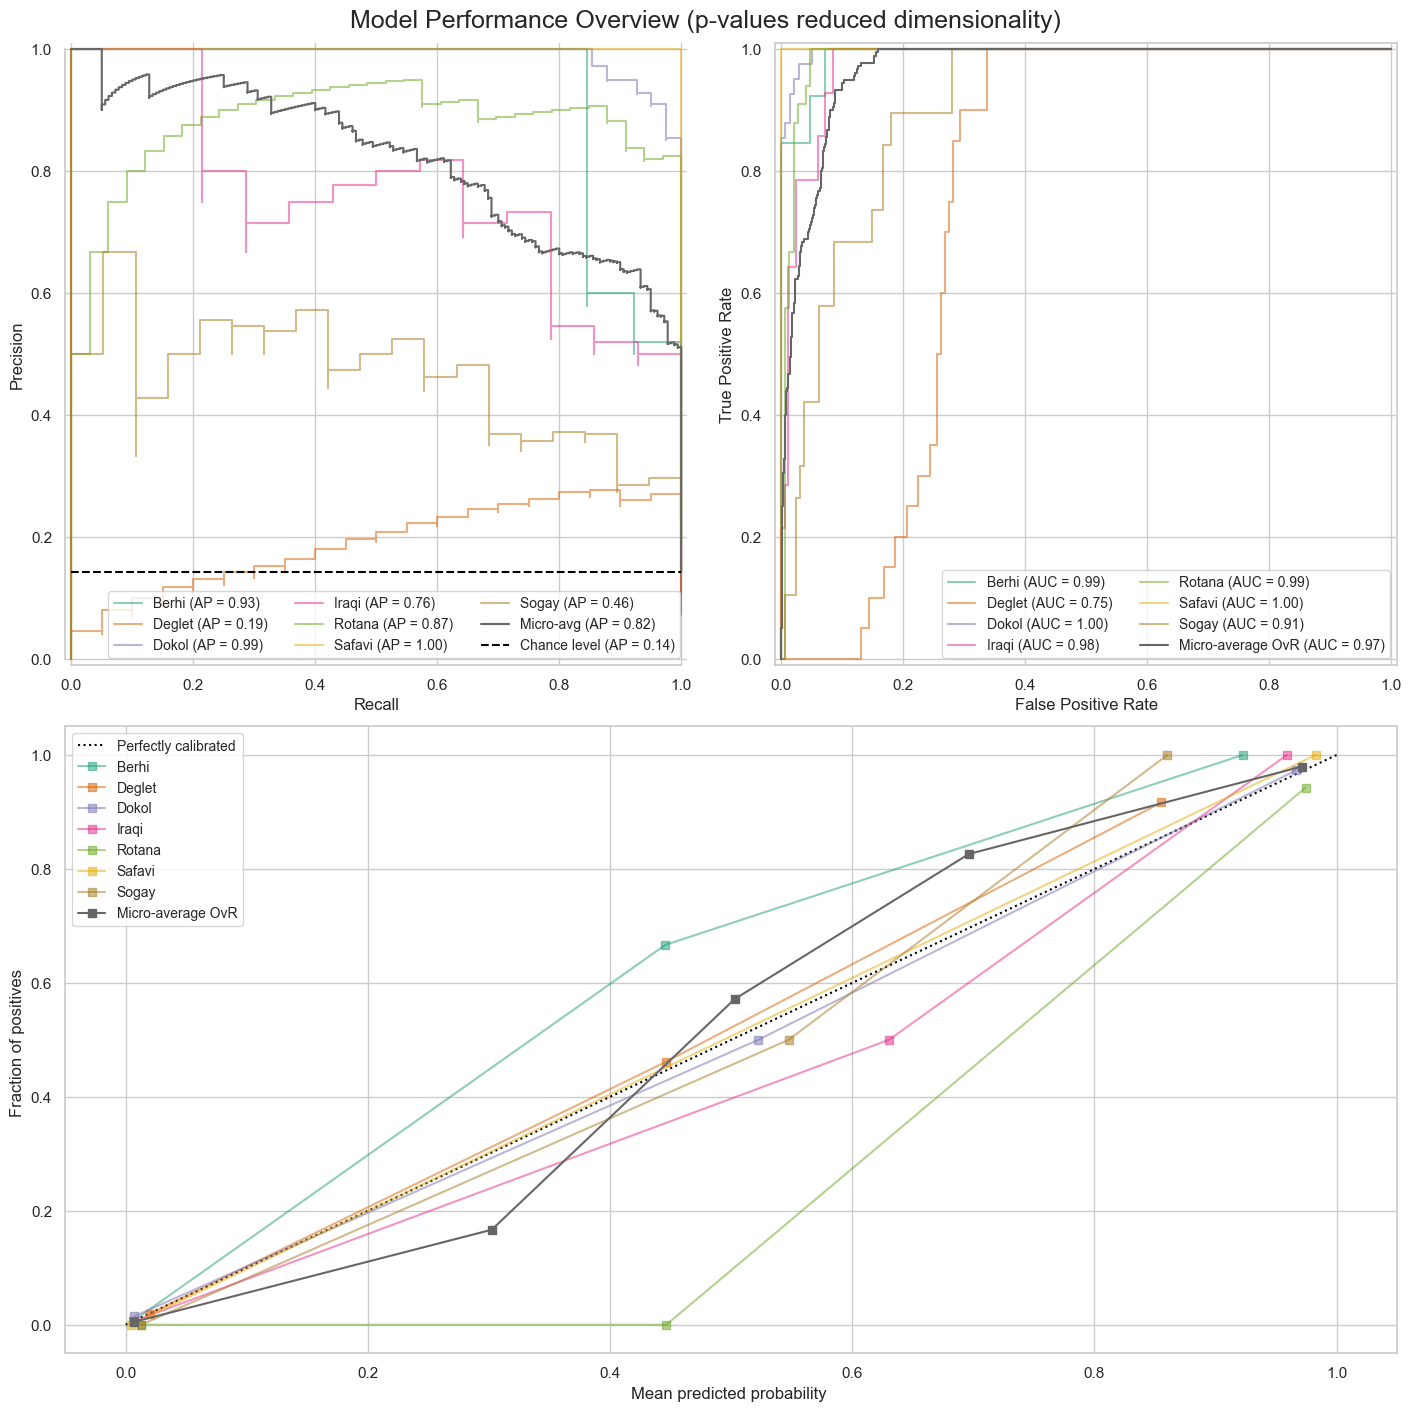

In [18]:
y_score_0 = clf_0.decision_function(scaler_0.transform(x_test.drop(columns=minor_features)))
y_proba_0 = clf_0.predict_proba(scaler_0.transform(x_test.drop(columns=minor_features)))
eval_summary(y_score_0, y_proba_0, y_test, title='Model Performance Overview (p-values reduced dimensionality)')

### Attempt II - Reducing feature vector manually based on feature groupings

              precision    recall  f1-score   support

       BERHI     0.7500    0.6923    0.7200        13
      DEGLET     0.6522    0.7500    0.6977        20
       DOKOL     0.9487    0.9024    0.9250        41
       IRAQI     0.8462    0.7857    0.8148        14
      ROTANA     0.9167    1.0000    0.9565        33
      SAFAVI     0.9756    1.0000    0.9877        40
       SOGAY     0.8125    0.6842    0.7429        19

    accuracy                         0.8778       180
   macro avg     0.8431    0.8307    0.8349       180
weighted avg     0.8792    0.8778    0.8768       180



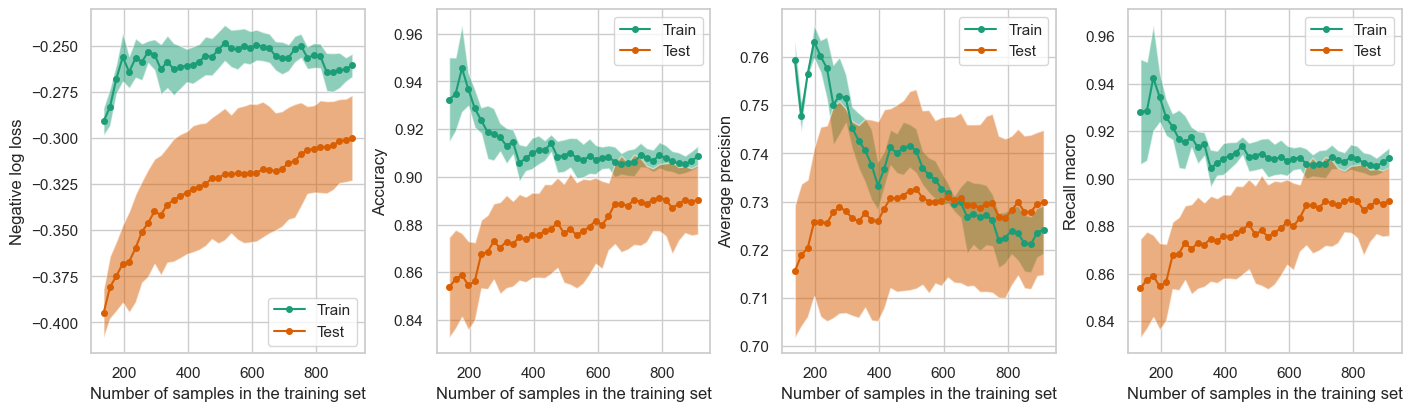

In [19]:
NEW_COLS = set([i[:-2] if i[-2:] in ['RR', 'RG', 'RB'] or i[-2] == '_' else i for i in features.columns]); NEW_COLS.remove('CONVEX_AREA')
def reduce_features_custom(data, new_cols=NEW_COLS):
    return pd.DataFrame({mean_feat: data[[feat for feat in data.columns if mean_feat in feat]].mean(axis=1) 
                                     for mean_feat in new_cols})
x_train_reduced = reduce_features_custom(x_train) 
clf_1, _, x_train_1, y_train_1, scaler_1 = train(LogisticRegression,
                                                     x_train_reduced, y_train,
                                                     penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
x_test_ = scaler_1.transform( reduce_features_custom(x_test) )
print(metrics.classification_report(y_test, clf_1.predict(x_test_),
            labels=list(range(N_CLASSES)), target_names=list(fruits.Class.unique()),  digits=4))
view_learning_curve(clf_1, x_train_1, y_train_1, ['neg_log_loss', 'accuracy', 'average_precision', 'recall_macro'], r=1, c=4)


c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


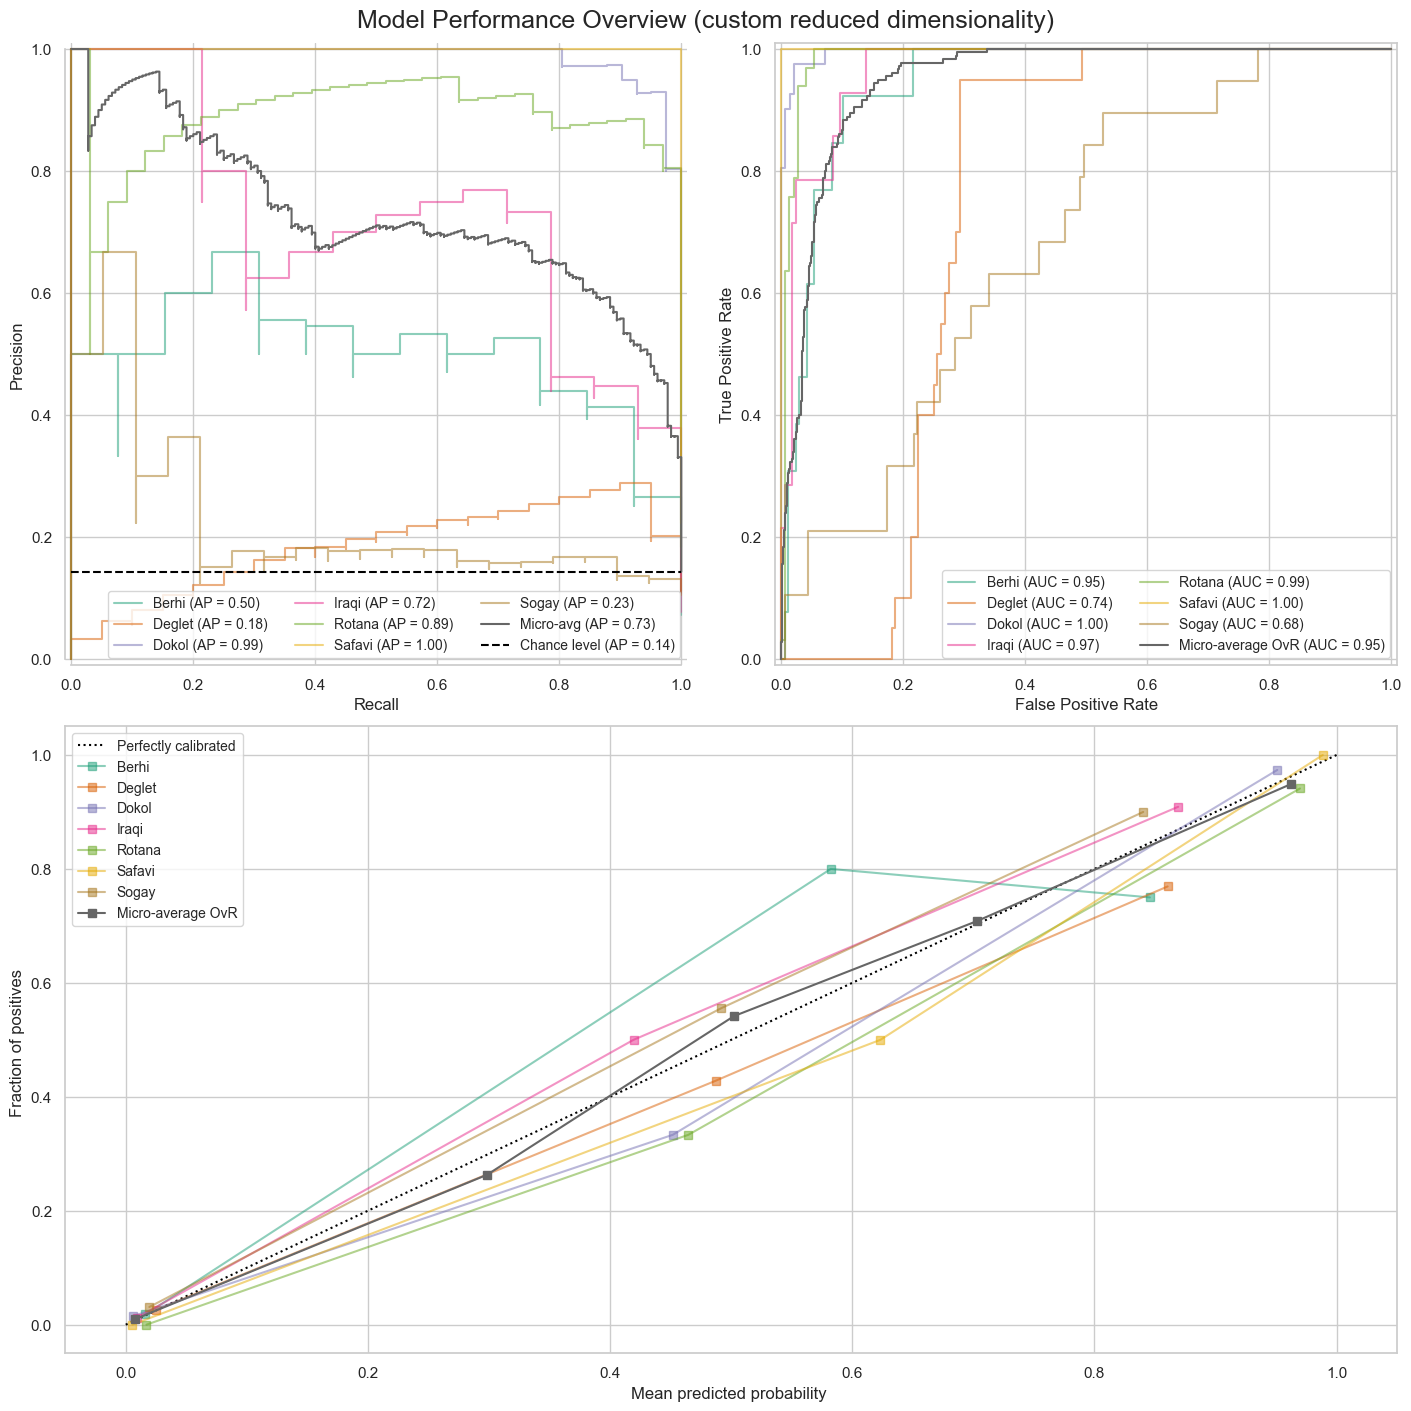

In [20]:
y_score_1 = clf_1.decision_function(scaler_1.transform(reduce_features_custom(x_test)))
y_proba_1 = clf_1.predict_proba(scaler_1.transform(reduce_features_custom(x_test) ))
eval_summary(y_score_1, y_proba_1, y_test, title='Model Performance Overview (custom reduced dimensionality)')

### Attempt III
#### Ensemble Learning : Horizontal Split 
- Split the data horizontally to D1 (4 Classes) and D2 (3 Classes)
- Train M1 on D1 and M2 on D2
- Train N to detect with Group the instance belongs to
- Linear Ensemble Learning using N as weights : N*M1 + (1-N)\*M2

In [21]:
def split_classes(data, map_dict=num_to_class, split='knn', n=SPLIT_CLASSES_N):
    data = data.groupby('Class').mean()
    scaler = StandardScaler().fit(data)
    data_s =  pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    if split == 'knn':
        knn = NearestNeighbors(n_neighbors=n).fit(data_s)
        _, positions = knn.kneighbors(data_s.iloc[:1]) 
        group_d1 = data_s.index[data_s.index.isin(pd.Series(positions[0]).map(map_dict))]
        group_d2 = data_s.index[~data_s.index.isin(pd.Series(positions[0]).map(map_dict))]
    elif split == 'normal':
        class_cv = (data_s.mean(axis=1)/data_s.std(axis=1)).sort_values()
        group_d1, group_d2 = class_cv[:n].index, class_cv[n:].index
    return group_d1, group_d2

group_d1, group_d2 = split_classes(fruits)
group_d1, group_d2

(Index(['BERHI', 'IRAQI', 'ROTANA', 'SOGAY'], dtype='object', name='Class'),
 Index(['DEGLET', 'DOKOL', 'SAFAVI'], dtype='object', name='Class'))

In [22]:
x_train, x_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=TEST_SIZE, random_state=SEED)
### Train
x_train_d1, y_train_d1 = x_train[y_train.isin(group_d1.map(class_to_num))], y_train[y_train.isin(group_d1.map(class_to_num))]
x_train_d2, y_train_d2 = x_train[y_train.isin(group_d2.map(class_to_num))], y_train[y_train.isin(group_d2.map(class_to_num))]
### Test
x_test_d1, y_test_d1 = x_test[y_test.isin(group_d1.map(class_to_num))], y_test[y_test.isin(group_d1.map(class_to_num))]
x_test_d2, y_test_d2 = x_test[y_test.isin(group_d2.map(class_to_num))], y_test[y_test.isin(group_d2.map(class_to_num))]
### Model N target vectors
y_train_n = y_train.map({i:1 if i in group_d1.map(class_to_num) else 0 for i in range(N_CLASSES)})
y_test_n = y_test.map({i:1 if i in group_d1.map(class_to_num) else 0 for i in range(N_CLASSES)})

print(x_train_d1.shape, y_train_d1.shape, x_train_d2.shape, y_train_d2.shape)
print(x_test_d1.shape, y_test_d1.shape, x_test_d2.shape, y_test_d2.shape)

(318, 34) (318,) (399, 34) (399,)
(79, 34) (79,) (101, 34) (101,)


In [23]:
def ensemble_model_predict(x, model_d ,model_1, model_2, scaler_d, scaler_1, scaler_2, minor_features_1, minor_features_2):
    """"""
    preds_1 = model_1.predict( scaler_1.transform(x.drop(columns=minor_features_1)) )
    preds_2 = model_2.predict( scaler_2.transform(x.drop(columns=minor_features_2)) )
    batch_pred = model_d.predict(scaler_d.transform(x))
    final_preds = batch_pred * preds_1 + (1-batch_pred) * preds_2
    return final_preds

def ensemble_model_predict_proba(x, model_d ,model_1, model_2, scaler_d, scaler_1, scaler_2, minor_features_1, 
                            minor_features_2, group_1=group_d1, group_2=group_d2, map_dict=class_to_num, n=N_CLASSES):
    """"""
    deci_1 = model_1.predict_proba( scaler_1.transform(x.drop(columns=minor_features_1)) )
    deci_2 = model_2.predict_proba( scaler_2.transform(x.drop(columns=minor_features_2)) )
    batch_pred = model_d.predict(scaler_d.transform(x))
    deci_1_ = pd.DataFrame(deci_1 @ label_binarize(group_1.map(map_dict), classes=list(range(n))))
    deci_2_ = pd.DataFrame(deci_2 @ label_binarize(group_2.map(map_dict), classes=list(range(n))))
    out_1 = pd.concat([deci_1_[batch_pred.astype(bool)], deci_1_[~batch_pred.astype(bool)].abs().apply(lambda x: x*0)]).sort_index()
    out_2 = pd.concat([deci_2_[~batch_pred.astype(bool)], deci_2_[batch_pred.astype(bool)].abs().apply(lambda x: x*0)]).sort_index()
    return out_1.to_numpy() + out_2.to_numpy()

def ensemble_model_decision(x, model_d ,model_1, model_2, scaler_d, scaler_1, scaler_2, minor_features_1, 
                            minor_features_2, group_1=group_d1, group_2=group_d2, map_dict=class_to_num, n=N_CLASSES):
    """"""
    deci_1 = model_1.decision_function( scaler_1.transform(x.drop(columns=minor_features_1)) )
    deci_2 = model_2.decision_function( scaler_2.transform(x.drop(columns=minor_features_2)) )
    batch_pred = model_d.predict(scaler_d.transform(x))
    deci_1_ = pd.DataFrame(deci_1 @ label_binarize(group_1.map(map_dict), classes=list(range(n))))
    deci_2_ = pd.DataFrame(deci_2 @ label_binarize(group_2.map(map_dict), classes=list(range(n))))
    out_1 = pd.concat([deci_1_[batch_pred.astype(bool)], deci_1_[~batch_pred.astype(bool)].abs().apply(lambda x: -x)]).sort_index()
    out_2 = pd.concat([deci_2_[~batch_pred.astype(bool)], deci_2_[batch_pred.astype(bool)].abs().apply(lambda x: -x)]).sort_index()
    return out_1.to_numpy() + out_2.to_numpy()

In [24]:
### Better performance with reduced feature vector
clf_d1, _, x_train_smote_d1, y_train_smote_d1, scaler_d1 = train(LogisticRegression,
                                                     x_train_d1.drop(columns=minor_features), y_train_d1,
                                                     penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
x_test_d1_ = scaler_d1.transform(x_test_d1.drop(columns=minor_features))
print(f'{20*'*'} M1 MODEL {20*'*'}\n Classes : {list(group_d1)}')
print(metrics.classification_report(y_test_d1, clf_d1.predict(x_test_d1_), digits=4))

### ~ Same performance with full and reduced feature vector
clf_d2, _, x_train_smote_d2, y_train_smote_d2, scaler_d2 = train(LogisticRegression,
                                                     x_train_d2.drop(columns=minor_features), y_train_d2,
                                                     penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
x_test_d2_ = scaler_d2.transform(x_test_d2.drop(columns=minor_features))
print(f'{20*'*'} M2 MODEL {20*'*'}\n Classes : {list(group_d2)}')
print(metrics.classification_report(y_test_d2, clf_d2.predict(x_test_d2_), digits=4))

# ### Better performance with full feature vector
# clf_n, _, x_train_smote_n, y_train_smote_n, scaler_n = train(LogisticRegression,
#                                                      x_train, y_train_n,
#                                                      penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
# x_test_ = scaler_n.transform(x_test)
# print(f'{20*'*'} N MODEL {20*'*'}')
# print(metrics.classification_report(y_test_n, clf_n.predict(x_test_), digits=4))

### Better performance with full feature vector
clf_n, _, x_train_smote_n, y_train_smote_n, scaler_n = train(KNeighborsClassifier,
                                                     x_train, y_train_n,
                                                     n_neighbors=6, weights='distance', random_state=SEED)
x_test_ = scaler_n.transform(x_test)
print(f'{20*'*'} N MODEL {20*'*'}')
print(metrics.classification_report(y_test_n, clf_n.predict(x_test_), digits=4))

print(f'{20*'*'} FINAL MODEL {20*'*'}')
final_preds = ensemble_model_predict(x_test, clf_n, clf_d1, clf_d2, scaler_n, scaler_d1, scaler_d2, minor_features, minor_features)
final_preds_proba = ensemble_model_predict_proba(x_test, clf_n, clf_d1, clf_d2, scaler_n, scaler_d1, scaler_d2, minor_features, minor_features)
ensemble_deci = ensemble_model_decision(x_test, clf_n, clf_d1, clf_d2, scaler_n, scaler_d1, scaler_d2, minor_features, minor_features)
print(metrics.classification_report(y_test, final_preds, digits=4))

******************** M1 MODEL ********************
 Classes : ['BERHI', 'IRAQI', 'ROTANA', 'SOGAY']
              precision    recall  f1-score   support

           0     1.0000    0.8462    0.9167        13
           3     0.9286    0.9286    0.9286        14
           4     0.9429    1.0000    0.9706        33
           6     1.0000    1.0000    1.0000        19

    accuracy                         0.9620        79
   macro avg     0.9679    0.9437    0.9540        79
weighted avg     0.9635    0.9620    0.9613        79

******************** M2 MODEL ********************
 Classes : ['DEGLET', 'DOKOL', 'SAFAVI']
              precision    recall  f1-score   support

           1     0.8636    0.9500    0.9048        20
           2     0.9744    0.9268    0.9500        41
           5     1.0000    1.0000    1.0000        40

    accuracy                         0.9604       101
   macro avg     0.9460    0.9589    0.9516       101
weighted avg     0.9626    0.9604    0.9608    

c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


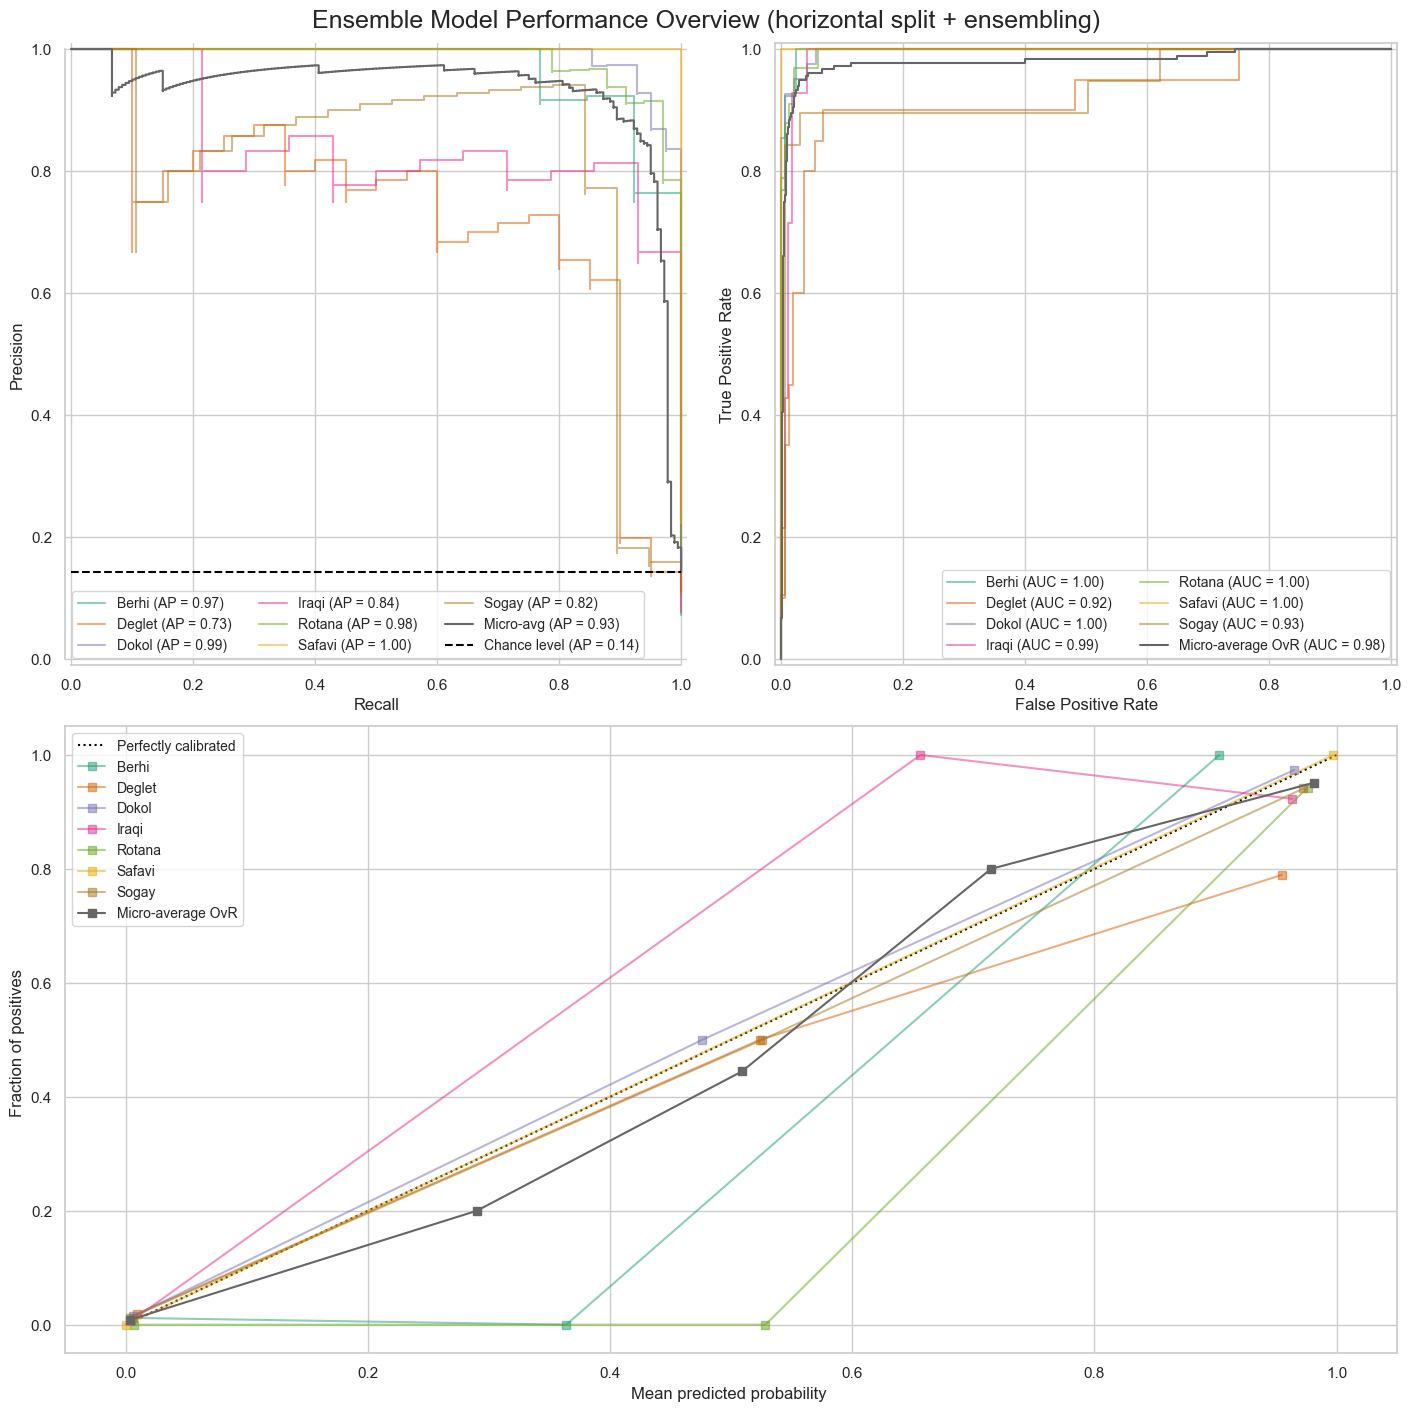

In [25]:
eval_summary(ensemble_deci, final_preds_proba, y_test, title='Ensemble Model Performance Overview (horizontal split + ensembling)')

# Comparing Models

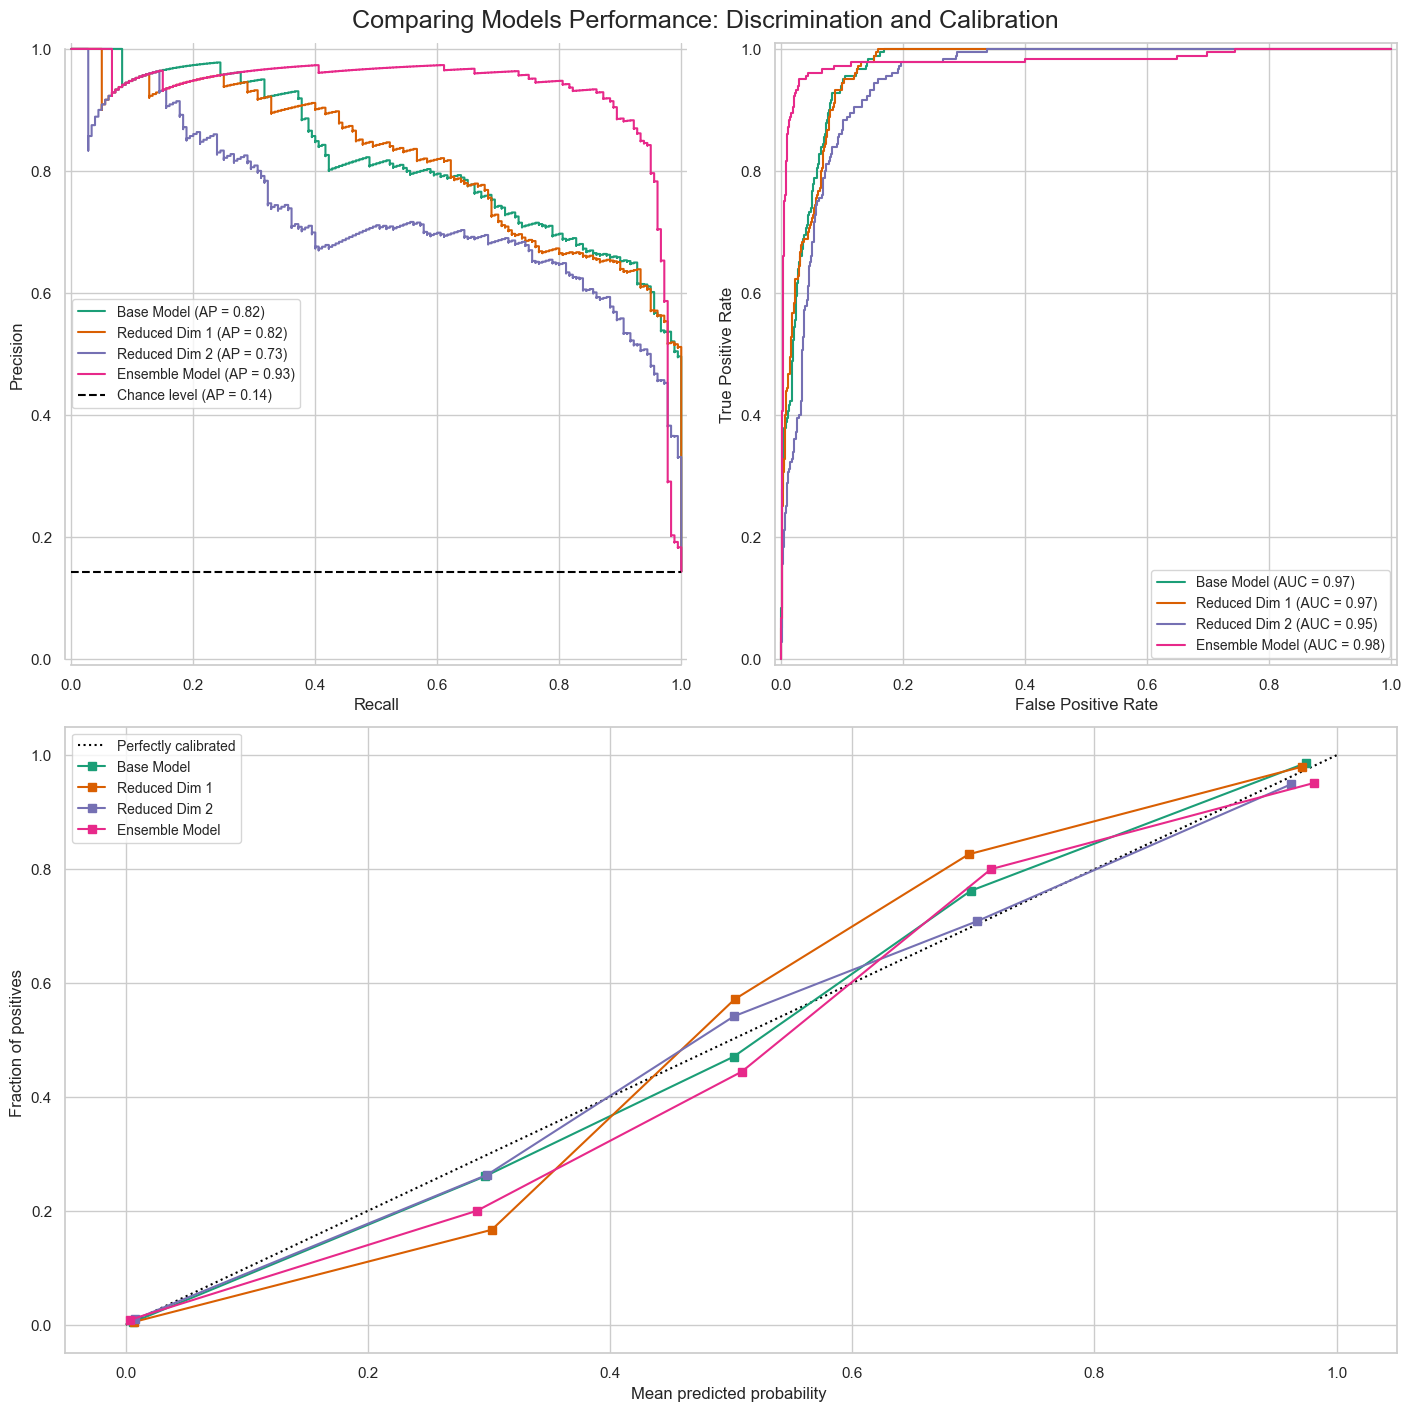

In [26]:
def compare_models(y_scores, y_probas, y_test, names, size=[14,14], title=''):
    fig, ax = plt.subplot_mosaic([['pr', 'roc'],['cal', 'cal']], figsize=size, layout='constrained')
    for i in range(len(y_scores)):
        plot_pr_curve(ax['pr'], y_scores[i], y_test, name=names[i], chance_level=False if i<len(y_scores)-1 else True)
        plot_roc_curve(ax['roc'], y_scores[i], y_test, name=names[i])
        plot_calibration_curve(ax['cal'], y_probas[i], y_test, name=names[i])
    fig.suptitle(title, size=18)

compare_models([y_score, y_score_0, y_score_1, ensemble_deci], [y_proba, y_proba_0, y_proba_1, final_preds_proba], y_test,
               names=['Base Model', 'Reduced Dim 1', 'Reduced Dim 2', 'Ensemble Model'], title='Comparing Models Performance: Discrimination and Calibration')

# Extra 
### Exploring feature groups' impact on model performance

In [27]:
morph_features = features[features.columns[:12]]
shape_features = features[features.columns[12:16]]
color_features = features[features.columns[16:]]

# %%capture --no-stderr
### MORPH
x_train_m, x_test_m, y_train_m, y_test_m = train_test_split(morph_features, target, test_size=TEST_SIZE, random_state=SEED)
clf_m, _, x_train_m_, y_train_m_, scaler_m = train(LogisticRegression,
                                                     x_train_m, y_train_m,
                                                     penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
x_test_m_ = scaler_m.transform(x_test_m)
print(' --- MORPHOLOGICAL FEATURES --- \n', metrics.classification_report(y_test_m, clf_m.predict(x_test_m_), 
            labels=list(range(7)), target_names=list(fruits.Class.unique()),  digits=4))

### SHAPE
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(shape_features, target, test_size=TEST_SIZE, random_state=SEED)
clf_s, _, x_train_s_, y_train_s_, scaler_s = train(LogisticRegression,
                                                     x_train_s, y_train_s,
                                                     penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
x_test_s_ = scaler_s.transform(x_test_s)
print(' --- SHAPE FEATURES --- \n', metrics.classification_report(y_test_s, clf_s.predict(x_test_s_), 
            labels=list(range(7)), target_names=list(fruits.Class.unique()),  digits=4))

### COLOR
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(color_features, target, test_size=TEST_SIZE, random_state=SEED)
clf_c, _, x_train_c_, y_train_c_, scaler_c = train(LogisticRegression,
                                                     x_train_c, y_train_c,
                                                     penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
x_test_c_ = scaler_c.transform(x_test_c)
print(' --- COLOR FEATURES --- \n', metrics.classification_report(y_test_c, clf_c.predict(x_test_c_), 
            labels=list(range(7)), target_names=list(fruits.Class.unique()),  digits=4))

 --- MORPHOLOGICAL FEATURES --- 
               precision    recall  f1-score   support

       BERHI     0.5000    0.5833    0.5385        12
      DEGLET     0.5294    0.6429    0.5806        14
       DOKOL     0.9623    0.9623    0.9623        53
       IRAQI     0.6429    0.6000    0.6207        15
      ROTANA     0.8182    0.8182    0.8182        33
      SAFAVI     0.9000    0.7297    0.8060        37
       SOGAY     0.4737    0.5625    0.5143        16

    accuracy                         0.7722       180
   macro avg     0.6895    0.6998    0.6915       180
weighted avg     0.7885    0.7722    0.7775       180

 --- SHAPE FEATURES --- 
               precision    recall  f1-score   support

       BERHI     0.4615    0.5000    0.4800        12
      DEGLET     0.4706    0.5714    0.5161        14
       DOKOL     0.9623    0.9623    0.9623        53
       IRAQI     0.5882    0.6667    0.6250        15
      ROTANA     0.7143    0.7576    0.7353        33
      SAFAVI     0